# Проект. Создание рекомендательной системы. Часть 1

## Описание задачи

На этот раз мы работаем с большим каталогом — более 70 млн треков. Чтобы пользователям было легче ориентироваться в столь обширном музыкальном потоке, нужно создать эффективную систему персональных рекомендаций.

Для этого нужно облегчить пользовательский опыт, создав систему персональных рекомендаций.

## Данные

Данные находятся в трёх файлах.

Данные о треках — в файле `tracks.parquet`:

- `track_id` — идентификатор музыкального трека;
- `albums` — список идентификаторов альбомов, содержащих трек;
- `artists` — список идентификаторов исполнителей трека;
- `genres` — список идентификаторов жанров, к которым принадлежит трек.

Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:

- `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
- `type` — тип идентификатора;
- `name` — имя (название) каталожной единицы.

Данные о том, какие пользователи прослушали тот или иной трек, — в файле `interactions.parquet` :

- `user_id` — идентификатор пользователя,
- `track_id` — идентификатор музыкального трека,
- `track_seq` — номер места трека в истории пользователя,
- `started_at` — дата начала прослушивания трека.

### Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from implicit.als import AlternatingLeastSquares
import sklearn.preprocessing
import warnings
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm 

In [2]:
warnings.filterwarnings('ignore')

## === ЭТАП 1 ===

### 1.1 Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
catalog_names = pd.read_parquet("./data/catalog_names.parquet")
interactions = pd.read_parquet("./data/interactions.parquet")
tracks = pd.read_parquet("./data/tracks.parquet")

In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


За основу возьмем взаимодействия ~1,3 млн пользователей. 

In [5]:
interactions = interactions.sample(frac=0.006, random_state=42)
tracks = tracks[tracks['track_id'].isin(interactions['track_id'])]

interactions.info()
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1335779 entries, 130 to 21
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1335779 non-null  int32         
 1   track_id    1335779 non-null  int32         
 2   track_seq   1335779 non-null  int16         
 3   started_at  1335779 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 33.1 MB
<class 'pandas.core.frame.DataFrame'>
Index: 253254 entries, 4 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  253254 non-null  int64 
 1   albums    253254 non-null  object
 2   artists   253254 non-null  object
 3   genres    253254 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.7+ MB


In [6]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [7]:
interactions.head()

,user_id,track_id,track_seq,started_at
130,844258,3581309,131,2022-06-05
433,1091434,14937363,434,2022-06-29
526,73981,48591660,527,2022-09-26
9,78605,732405,10,2022-09-14
1202,1273064,40339506,1203,2022-08-24


In [8]:
tracks.head()

,track_id,albums,artists,genres
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11]
9,144,"[13, 99422]",[90],"[59, 102]"
12,147,"[13, 99422]",[90],"[59, 102]"
14,149,"[13, 99422]",[90],"[59, 102]"


### 1.2 Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [9]:
# Проверка наличия треков с неизвестными исполнителями, альбомами, жанрами
# Разделим catalog_names по типам для удобства
artists = catalog_names[catalog_names['type'] == 'artist']
albums = catalog_names[catalog_names['type'] == 'album']
genres = catalog_names[catalog_names['type'] == 'genre']

In [10]:
artists.head()

,id,type,name
658724,4,artist,Kenny Dorham
658725,5,artist,Max Roach
658726,7,artist,Francis Rossi
658727,9,artist,Status Quo
658728,12,artist,Phil Everly


In [11]:
albums.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [12]:
genres.head()

,id,type,name
812305,0,genre,all
812306,1,genre,eastern
812307,2,genre,rusrock
812308,3,genre,rusrap
812309,4,genre,postrock


Проверим, есть ли неизвестные исполнители, альбомы, жанры

In [13]:
artistIds = artists['id'].values
unknown_artists = (tracks['artists']
                   .apply(lambda x: [artist for artist in x if artist not in artistIds])
                   .explode()
                   .unique())

In [14]:
albumIds = albums['id'].values;
unknown_albums = (tracks['albums']
                  .apply(lambda x: [album for album in x if album not in albumIds])
                  .explode()
                  .unique())

In [15]:
genreIds = genres['id'].values
unknown_genres = (tracks['genres']
                  .apply(lambda x: [genre for genre in x if genre not in genreIds])
                  .explode()
                  .unique())

In [16]:
# Выводим количество неизвестных артистов, альбомов, жанров
print("Количество треков с неизвестными исполнителями:", len(unknown_artists))
print("Количество треков с неизвестными альбомами:", len(unknown_albums))
print("Количество треков с неизвестными жанрами:", len(unknown_genres))

Количество треков с неизвестными исполнителями: 1
Количество треков с неизвестными альбомами: 1
Количество треков с неизвестными жанрами: 28


In [17]:
print(unknown_artists)

[nan]


In [18]:
print(unknown_albums)

[nan]


In [19]:
print(unknown_genres)

[nan 162 163 151 157 169 164 161 158 155 165 154 156 159 168 167 153 160
 152 133 126 132 146 131 130 135 166 134]


### 1.3 Выводы

Есть 30 неизвестных жанров. Заменим их на существующий жанр ALL (id=0)

In [20]:
genres[genres['id'] == 0]

,id,type,name
812305,0,genre,all


In [21]:
unknown_genres_set = set(unknown_genres)

In [22]:
upd_tracks = tracks.copy()

In [23]:
upd_tracks['genres'] = upd_tracks['genres'].apply(lambda genres_list: [0 if genre in unknown_genres_set else genre for genre in genres_list])

In [24]:
upd_unknown_genres = (upd_tracks['genres']
                  .apply(lambda x: [genre for genre in x if genre not in genreIds])
                  .explode()
                  .unique())

In [25]:
print(upd_unknown_genres)

[nan]


## === ЭТАП 2 ===

### 2.1 EDA

#### 2.1.1 Распределение количества прослушанных треков.

In [26]:
user_track_counts = interactions['user_id'].value_counts()

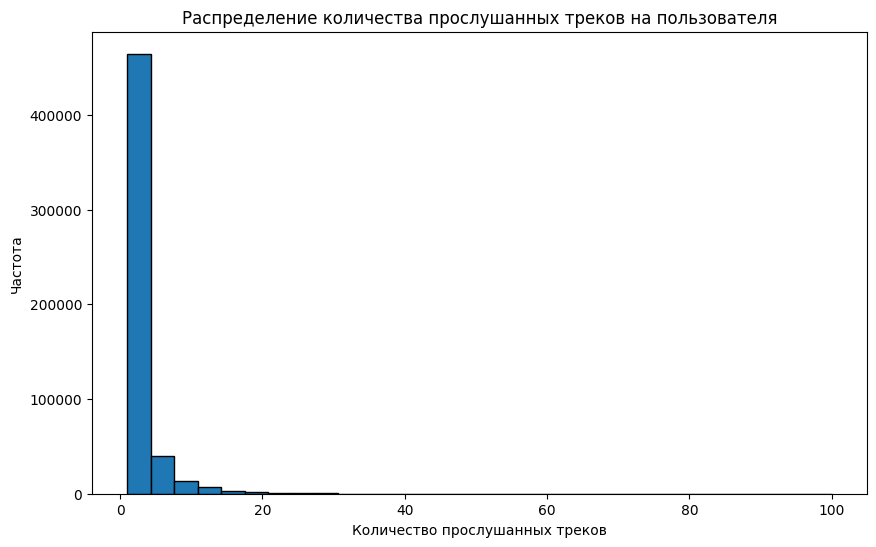

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(user_track_counts, bins=30, edgecolor='black')
plt.title("Распределение количества прослушанных треков на пользователя")
plt.xlabel("Количество прослушанных треков")
plt.ylabel("Частота")
plt.show()

#### 2.1.2 Наиболее популярные треки

In [28]:
popular_tracks = interactions['track_id'].value_counts().head(10)
popular_track_names = pd.merge(popular_tracks.rename('count').reset_index(), 
                               catalog_names[catalog_names['type'] == 'track'][['id', 'name']], 
                               left_on='track_id', right_on='id', 
                               how='left').drop(columns=['id'])
popular_track_names.rename(columns={'index': 'track_id', 'name': 'track_name'}, inplace=True)

In [29]:
print("Наиболее популярные треки:")
print(popular_track_names)

Наиболее популярные треки:
   track_id  count               track_name
0  33311009    698                 Believer
1     53404    631  Smells Like Teen Spirit
2    178529    589                     Numb
3  35505245    581               I Got Love
4  65851540    555                   Юность
5  24692821    533           Way Down We Go
6  29544272    516                    Human
7    795836    512        Shape Of My Heart
8  32947997    511             Shape of You
9  39257277    509               In My Mind


#### 2.1.3 Наиболее популярные жанры

In [30]:
# Разворачиваем список жанров в interactions и upd_tracks для анализа
track_genres = upd_tracks[['track_id', 'genres']].explode('genres')
merged_interactions = interactions.merge(track_genres, on='track_id', how='left')
genre_counts = merged_interactions['genres'].value_counts().head(10)

In [31]:
genre_counts.head(20)

genres
11     333843
75     227259
102    186665
20     159767
3      152221
68     120304
16      97624
2       78689
14      76725
47      74522
Name: count, dtype: int64

In [32]:
# Подключаем названия жанров
popular_genres = pd.merge(genre_counts.rename('count').reset_index(), 
                          catalog_names[catalog_names['type'] == 'genre'][['id', 'name']], 
                          left_on='genres', right_on='id', 
                          how='left').drop(columns=['id'])
popular_genres.rename(columns={'genres': 'genre_id', 'name': 'genre_name'}, inplace=True)

In [33]:
print("\nНаиболее популярные жанры:")
print(popular_genres)


Наиболее популярные жанры:
   genre_id   count   genre_name
0        11  333843          pop
1        75  227259          rap
2       102  186665      allrock
3        20  159767       ruspop
4         3  152221       rusrap
5        68  120304  electronics
6        16   97624        dance
7         2   78689      rusrock
8        14   76725         rock
9        47   74522        metal


#### 2.1.3 Треки, которые никто не прослушал

In [34]:
all_tracks = set(upd_tracks['track_id'].unique())
listened_tracks = set(interactions['track_id'].unique())

In [35]:
unlistened_tracks = all_tracks - listened_tracks

In [36]:
# Получаем названия треков, которые никто не слушал
unlistened_tracks_df = catalog_names[(catalog_names['type'] == 'track') & (catalog_names['id'].isin(unlistened_tracks))]
print("\nТреки, которые никто не прослушал:")
print(unlistened_tracks_df[['id', 'name']])


Треки, которые никто не прослушал:
Empty DataFrame
Columns: [id, name]
Index: []


### 2.2 Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [37]:
upd_tracks.head()

,track_id,albums,artists,genres
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11]
9,144,"[13, 99422]",[90],"[59, 102]"
12,147,"[13, 99422]",[90],"[59, 102]"
14,149,"[13, 99422]",[90],"[59, 102]"


In [38]:
genresDict = genres.set_index('id')['name'].to_dict()

In [39]:
upd_tracks['genres'] = upd_tracks['genres'].apply(lambda genres_list: [genresDict[genreId] for genreId in genres_list])

In [40]:
albumsDict = albums.set_index('id')['name'].to_dict()
upd_tracks['albums'] = upd_tracks['albums'].apply(lambda albums_list: [albumsDict[albumId] for albumId in albums_list])

In [41]:
artistsDict = artists.set_index('id')['name'].to_dict()
upd_tracks['artists'] = upd_tracks['artists'].apply(lambda artists_list: [artistsDict[artistId] for artistId in artists_list])

In [42]:
upd_tracks.rename(columns={'track_id': 'item_id'}, inplace=True)

In [43]:
upd_tracks.head()

,item_id,albums,artists,genres
4,138,"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]
7,141,"[Wild Young Hearts, Wild Young Hearts, I Am Wo...",[Noisettes],[pop]
9,144,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"
12,147,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"
14,149,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"


In [44]:
interactions.rename(columns={'track_id': 'item_id'}, inplace=True)

In [45]:
interactions.head()

,user_id,item_id,track_seq,started_at
130,844258,3581309,131,2022-06-05
433,1091434,14937363,434,2022-06-29
526,73981,48591660,527,2022-09-26
9,78605,732405,10,2022-09-14
1202,1273064,40339506,1203,2022-08-24


### 2.3 Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [46]:
upd_tracks.to_parquet("./data/items.parquet")

In [47]:
interactions.to_parquet("./data/events.parquet")

### 2.4 Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [48]:
del tracks
del upd_tracks
del interactions
del catalog_names

## === ЭТАП 3 ===

### 3.1 Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [49]:
items = pd.read_parquet("./data/items.parquet")

In [50]:
events = pd.read_parquet("./data/events.parquet")

### 3.2 Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки: в тренировочную все данные до 16 декабря 2022 года (не включительно).

In [51]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

In [52]:
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [53]:
# перекодируем идентификаторы пользователей:
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [54]:
# перекодируем идентификаторы объектов:
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [55]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [56]:
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

In [57]:
print(len(users_train), len(users_test), len(common_users))

500267 70275 39814


«Холодные» пользователи — те, которые есть в test, но отсутствуют в train. Это соответствует хронологическому порядку, в котором и работает рекомендательная система.

In [58]:
cold_users = set(users_test) - set(users_train)

print(len(cold_users))

30461


### 3.3 Топ популярных

Рассчитаем рекомендации как топ популярных.

Завершите код, чтобы получить топ-100 наиболее популярных треках.

In [59]:
item_popularity = events_train \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), count_plays=("item_id", "count")).reset_index()
item_popularity["popularity_weighted"] = item_popularity["users"] * item_popularity["count_plays"]

# сортируем по убыванию взвешенной популярности
item_popularity = item_popularity.sort_values(by="popularity_weighted", ascending=False)

In [60]:
top_k_pop_items = item_popularity.head(100)

Добавив информацию о треках, можно просмотреть, какие попали в топ.

In [61]:
# добавляем информацию о треках
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["albums", "genres", "artists"]], on="item_id")

In [62]:
with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "albums", "genres", "artists", "count_plays", "popularity_weighted"]])

,item_id,albums,genres,artists,count_plays,popularity_weighted
0,33311009,"[Shape Of Pop, NOW That's What I Call Music, E...","[rock, allrock]",[Imagine Dragons],656,430336
1,53404,"[Nevermind, Nirvana, Nevermind, Nevermind, Nev...","[alternative, rock, allrock]",[Nirvana],625,390625
2,178529,"[Meteora, Meteora, Meteora, Meteora, 00s Rock ...","[numetal, metal]",[Linkin Park],588,345744
3,35505245,"[I Got Love, I Got Love]","[rusrap, rap]","[Miyagi & Эндшпиль, Рем Дигга]",557,310249
4,24692821,"[Way down We Go, Summer Music 2016, A/B, DFM D...",[indie],[KALEO],514,264196
5,795836,"[Ten Summoner's Tales, 25 Years, The Best Of 2...","[pop, rock, allrock]",[Sting],506,256036
6,29544272,"[Human, Human, Some Chillout Music, Music Made...","[soundtrack, indie]",[Rag'n'Bone Man],504,254016
7,37384,"[Stars: The Best Of The Cranberries 1992-2002,...","[rock, allrock]",[The Cranberries],493,243049
8,6705392,"[Elephant, Seven Nation Army, Pay Close Attent...",[alternative],[The White Stripes],492,242064
9,65851540,[Юность],"[pop, ruspop]",[Dabro],491,241081


In [63]:
top_k_pop_items.to_parquet("./data/top_popular.parquet")

### 3.4 Персональные рекомендации

Рассчитаем персональные рекомендации.

In [64]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train['user_id_enc'],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8
)

In [65]:
als_model = AlternatingLeastSquares(factors=50, iterations=20, regularization=0.05, random_state=42)
als_model.fit(user_item_matrix_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [66]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [67]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, 
    N=10
)

Код возвращает рекомендации как список списков, это не очень удобно. Преобразуем его в более удобный формат — табличный.

In [68]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist()}
)
als_recommendations = als_recommendations.explode(["item_id_enc"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

Сохраним полученные рекомендации в файл.

In [69]:
als_recommendations.to_parquet("./data/als_recommendations.parquet")

### 3.5 Похожие треки

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [70]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

In [71]:
max_similar_items = 10
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items + 1)

In [72]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]
similar_items = pd.DataFrame(columns=["item_id_enc", "sim_item_id_enc", "user_id_enc"])

# Преобразуем столбцы в соответствующие типы данных
similar_items["user_id_enc"] = similar_items["user_id_enc"].astype(int)
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype(int)

In [73]:
similar_items_list = []
for item_id, sim_item_ids, sim_scores in zip(train_item_ids_enc, sim_item_item_ids_enc.tolist(), sim_item_scores.tolist()):
    similar_items_list.append((item_id, sim_item_ids, sim_scores))

In [74]:
# Создадим DataFrame из списка
similar_items = pd.DataFrame(similar_items_list, columns=["item_id_enc", "sim_item_id_enc", "user_id_enc"])
similar_items = similar_items.explode(["sim_item_id_enc", "user_id_enc"], ignore_index=True)

# Преобразуем столбцы в соответствующие типы данных
similar_items["user_id_enc"] = similar_items["user_id_enc"].astype(int)
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype(int)

In [75]:
# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])

In [76]:
# получаем изначальные идентификаторы
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])

In [77]:
# убираем ненужные колонки
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

In [78]:
# Выводим результат
similar_items.head()

,user_id_enc,item_id_1,item_id_2
0,1,3581309,3581309
1,0,3581309,149855
2,0,3581309,241406
3,0,3581309,70736607
4,0,3581309,20575038


In [79]:
# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

Сохраним получившийся результат в файл

In [80]:
similar_items.to_parquet("./data/similar.parquet")

### 3.6 Построение признаков

Построим три признака, для ранжирующей модели.
1. Признак количества прослушиваний трека для каждого пользователя
2. Признак средней позиции прослушивания для каждого трека пользователя
3. Признак популярности трека: общее количество прослушиваний

In [81]:
# Создание уникальных числовых идентификаторов для пользователей и треков
user_id_map = {id: idx for idx, id in enumerate(events_train['user_id'].unique())}
item_id_map = {id: idx for idx, id in enumerate(events_train['item_id'].unique())}
events_train['user_id_enc'] = events_train['user_id'].map(user_id_map)
events_train['item_id_enc'] = events_train['item_id'].map(item_id_map)

In [82]:
# 1. Признак количества прослушиваний трека для каждого пользователя
play_count = events_train.groupby(['user_id_enc', 'item_id_enc']).size().reset_index(name='play_count')

# 2. Признак средней позиции прослушивания для каждого трека пользователя
avg_track_seq = events_train.groupby(['user_id_enc', 'item_id_enc'])['track_seq'].mean().reset_index(name='avg_track_seq')

# 3. Признак популярности трека: общее количество прослушиваний
item_popularity = events_train.groupby('item_id_enc').size().reset_index(name='item_popularity')

# Объединение признаков
features = play_count.merge(avg_track_seq, on=['user_id_enc', 'item_id_enc'])
features = features.merge(item_popularity, on='item_id_enc')

In [83]:
features.head()

,user_id_enc,item_id_enc,play_count,avg_track_seq,item_popularity
0,0,0,1,131.0,338
1,1096,0,1,634.0,338
2,1591,0,1,146.0,338
3,1654,0,1,11.0,338
4,1814,0,1,4.0,338


### 3.7 Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [84]:
# Шаг 1: Определение весов для sparse-матрицы
# Используем нормированное значение play_count и item_popularity как веса
features['weight'] = features['play_count'] * (1 + np.log1p(features['item_popularity']))

In [85]:
# Создание sparse-матрицы с весами
user_item_matrix_train = scipy.sparse.csr_matrix((
    features['weight'],
    (features['user_id_enc'], features['item_id_enc'])),
    shape=(len(user_id_map), len(item_id_map)),
    dtype=np.float32
)

In [86]:
# Шаг 4: Обучение модели ALS
als_model = AlternatingLeastSquares(factors=50, iterations=20, regularization=0.05, random_state=42)
als_model.fit(user_item_matrix_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [87]:
# Функция для получения рекомендаций для одного пользователя
def get_user_recommendations(user_id, user_idx, als_model, user_item_matrix_train, item_id_map):
    # Получаем рекомендации для текущего пользователя
    recommended_items, scores = als_model.recommend(
        userid=user_idx,
        user_items=user_item_matrix_train[user_idx],  # Передаем только данные для конкретного пользователя
        N=10  # Количество рекомендаций на пользователя
    )
    
    # Расшифровываем item_id
    recommended_item_ids = [list(item_id_map.keys())[list(item_id_map.values()).index(idx)] for idx in recommended_items]
    
    # Формируем рекомендации для пользователя
    user_recommendations = [{
        'user_id': user_id,
        'item_id': item_id,
        'score': score
    } for item_id, score in zip(recommended_item_ids, scores)]
    
    return user_recommendations

In [88]:
# Генерация рекомендаций для каждого пользователя с использованием многопоточности
recommendations = []

# Используем ThreadPoolExecutor для распараллеливания с tqdm
with ThreadPoolExecutor() as executor:
    # Запускаем задания и отслеживаем их с помощью tqdm
    futures = [
        executor.submit(get_user_recommendations, user_id, user_idx, als_model, user_item_matrix_train, item_id_map)
        for user_id, user_idx in user_id_map.items()
    ]
    
    # Используем tqdm для отображения прогресса в Jupyter
    for future in tqdm(futures, desc="Generating Recommendations", unit="user"):
        recommendations.extend(future.result())

Generating Recommendations:   0%|          | 0/500267 [00:00<?, ?user/s]

Сохраним получившийся результат в файл

In [94]:
# Шаг 6: Сохранение рекомендаций в parquet-файл
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_parquet('data/recommendations.parquet', index=False)

### 3.8 Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных
- персональных, полученных при помощи ALS
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [3]:
# Чтение данных
top_popular = pd.read_parquet('data/top_popular.parquet')
als_recommendations = pd.read_parquet('data/als_recommendations.parquet')
final_recommendations = pd.read_parquet('data/recommendations.parquet')

FileNotFoundError: [Errno 2] No such file or directory: 'data/recommendations.parquet'

In [ ]:
# Данные взаимодействий пользователей (необходимо загрузить для вычисления релевантности)
events = pd.read_parquet('data/events.parquet')  # Исходная история взаимодействий пользователей с треками

In [96]:
user_item_pairs = events[['user_id', 'item_id']].drop_duplicates()

# Словарь популярности для вычисления новизны
popularity_dict = dict(zip(top_popular['item_id'], top_popular['popularity_weighted']))

In [97]:
def calculate_metrics(recommendations, user_item_pairs, popularity_dict):
    # Уникальные пользователи и треки в рекомендациях
    unique_items = recommendations['item_id'].unique()
    
    # Метрика coverage
    coverage = len(unique_items) / len(top_popular['item_id'].unique())
    
    # Релевантные пары
    relevant_pairs = user_item_pairs.set_index(['user_id', 'item_id']).index
    recommended_pairs = recommendations.set_index(['user_id', 'item_id']).index
    
    # Метрика recall
    recall = len(recommended_pairs.intersection(relevant_pairs)) / len(relevant_pairs)
    
    # Метрика precision
    precision = len(recommended_pairs.intersection(relevant_pairs)) / len(recommended_pairs)
    
    # Метрика novelty
    novelty_scores = recommendations['item_id'].map(lambda x: popularity_dict.get(x, np.nan))
    novelty = novelty_scores.rank(method='max', ascending=False).mean()
    
    return recall, precision, coverage, novelty

In [98]:
# Рассчёт метрик для каждой группы рекомендаций
top_recall, top_precision, top_coverage, top_novelty = calculate_metrics(top_popular[['item_id']].assign(user_id=0), user_item_pairs, popularity_dict)
print("Top Popular Recommendations:")
print(f"Recall: {top_recall:.4f}, Precision: {top_precision:.4f}, Coverage: {top_coverage:.4f}, Novelty: {top_novelty:.4f}")

Top Popular Recommendations:
Recall: 0.0000, Precision: 0.0000, Coverage: 1.0000, Novelty: 53.4400


In [99]:
als_recall, als_precision, als_coverage, als_novelty = calculate_metrics(als_recommendations, user_item_pairs, popularity_dict)
print("\nALS Recommendations:")
print(f"Recall: {als_recall:.4f}, Precision: {als_precision:.4f}, Coverage: {als_coverage:.4f}, Novelty: {als_novelty:.4f}")


ALS Recommendations:
Recall: 0.2459, Precision: 0.0294, Coverage: 101.9400, Novelty: 144142.3736


In [100]:
final_recall, final_precision, final_coverage, final_novelty = calculate_metrics(final_recommendations, user_item_pairs, popularity_dict)
print("\nFinal Recommendations:")
print(f"Recall: {final_recall:.4f}, Precision: {final_precision:.4f}, Coverage: {final_coverage:.4f}, Novelty: {final_novelty:.4f}")


Final Recommendations:
Recall: 0.0000, Precision: 0.0000, Coverage: 4.5500, Novelty: 316434.1799


### === 3.9 Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.